In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Read data
df = pd.read_csv("accident_cleaned.csv")

# Features
df["ACCIDENT_TYPE_GROUPED"] = df["ACCIDENT_TYPE_DESC"].replace({
    "Collision with vehicle": "Collision",
    "Collision with a fixed object": "Collision",
    "collision with some other object": "Collision",
    "Struck Pedestrian": "Vulnerable Road User",
    "Struck animal": "Vulnerable Road User",
    "Vehicle overturned (no collision)": "Non-Collision",
    "No collision and no object struck": "Non-Collision",
    "Fall from or in moving vehicle": "Non-Collision"
})

df["IS_WEEKEND"] = df["DAY_WEEK_DESC"].isin(["Saturday", "Sunday"]).astype(int)

df["LIGHT_CONDITION_GROUPED"] = df["LIGHT_CONDITION"].replace({
    1: "Daylight", 5: "Twilight", 6: "Twilight", 2: "Darkness", 3: "Darkness", 4: "Darkness"
})

df["ROAD_GEOMETRY_GROUPED"] = df["ROAD_GEOMETRY_DESC"].replace({
    "Cross intersection": "Intersection",
    "T intersection": "Intersection",
    "Multiple intersection": "Intersection",
    "Y intersection": "Intersection",
    "Not at intersection": "Non-Intersection"
})

def categorize_speed(speed):
    if speed <= 40:
        return 'Very Low'
    elif speed <= 60:
        return 'Low'
    elif speed <= 80:
        return 'Medium'
    else:
        return 'High'
df["SPEED_ZONE_GROUPED"] = df["SPEED_ZONE"].apply(categorize_speed)

df["SURFACE_GROUPED"] = df["SURFACE_COND_DESC"].replace({
    "Dry": "Dry", "Wet": "Wet", "Icy": "Slippery", "Muddy": "Slippery", "Snowy": "Slippery"
})

df["ATMOSPH_GROUPED"] = df["ATMOSPH_COND_DESC"].replace({
    "Clear": "Clear", "Raining": "Rain/Snow", "Snowing": "Rain/Snow",
    "Strong winds": "Other Hazard", "Fog": "Other Hazard", "Dust": "Other Hazard", "Smoke": "Other Hazard"
})

# All features
features = [
    'ACCIDENT_TYPE_GROUPED', 'LIGHT_CONDITION_GROUPED', 'ROAD_GEOMETRY_GROUPED',
    'SPEED_ZONE_GROUPED', 'SURFACE_GROUPED', 'ATMOSPH_GROUPED', 'RMA', 'IS_WEEKEND'
]

target = 'SEVERITY'
X = df[features].copy()
y = df[target]

# Encoding categorical variables
for col in X.select_dtypes(include="object").columns:
    X[col] = LabelEncoder().fit_transform(X[col])

y = y - 1

# Divide the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [2]:

# Training the model
log_model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)
log_model.fit(X_train_scaled, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Validation set comparison
def print_report(name, y_true, y_pred):
    print(f"\n Validation Performance: {name} ")
    print(classification_report(y_true, y_pred, digits=4))

y_pred_log_val = log_model.predict(X_val_scaled)
y_pred_rf_val = rf_model.predict(X_val)
y_pred_xgb_val = xgb_model.predict(X_val)

print_report("Logistic Regression", y_val, y_pred_log_val)
print_report("Random Forest", y_val, y_pred_rf_val)
print_report("XGBoost", y_val, y_pred_xgb_val)


 Validation Performance: Logistic Regression 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       403
           1     0.4628    0.0409    0.0751      8515
           2     0.6032    0.9729    0.7447     13325

    accuracy                         0.5985     22243
   macro avg     0.3553    0.3379    0.2733     22243
weighted avg     0.5385    0.5985    0.4749     22243


 Validation Performance: Random Forest 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       403
           1     0.4774    0.2034    0.2853      8515
           2     0.6240    0.8716    0.7273     13325

    accuracy                         0.6000     22243
   macro avg     0.3671    0.3583    0.3375     22243
weighted avg     0.5566    0.6000    0.5449     22243


 Validation Performance: XGBoost 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       403
      

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight

## GridSearchCV model parameter tuning
# Logistic Regression
log_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}
log_grid = GridSearchCV(LogisticRegression(multi_class="multinomial", max_iter=500, class_weight='balanced'),
                        param_grid=log_param_grid,
                        scoring='f1_macro',
                        cv=3,
                        n_jobs=-1,
                        verbose=1)
log_grid.fit(X_train_scaled, y_train)
best_log_model = log_grid.best_estimator_
print("Best Logistic Regression Params:", log_grid.best_params_)

# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid=rf_param_grid,
                       scoring='f1_macro',
                       cv=3,
                       n_jobs=-1,
                       verbose=1)
rf_grid.fit(X_train, y_train)
best_rf_model = rf_grid.best_estimator_
print("Best Random Forest Params:", rf_grid.best_params_)

# XGBoost
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                        param_grid=xgb_param_grid,
                        scoring='f1_macro',
                        cv=3,
                        n_jobs=-1,
                        verbose=1)
xgb_grid.fit(X_train, y_train, **{'sample_weight': sample_weights})
best_xgb_model = xgb_grid.best_estimator_
print("Best XGBoost Params:", xgb_grid.best_params_)

# Evaluate the three best models on the validation set
def print_report(name, y_true, y_pred):
    print(f"\n Validation Performance: {name} ")
    print(classification_report(y_true, y_pred, digits=4))

y_pred_log_val = best_log_model.predict(X_val_scaled)
y_pred_rf_val = best_rf_model.predict(X_val)
y_pred_xgb_val = best_xgb_model.predict(X_val)

print_report("Logistic Regression (Tuned)", y_val, y_pred_log_val)
print_report("Random Forest (Tuned)", y_val, y_pred_rf_val)
print_report("XGBoost (Tuned)", y_val, y_pred_xgb_val)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Random Forest Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}

 Validation Performance: Logistic Regression (Tuned) 
              precision    recall  f1-score   support

           0     0.0317    0.5931    0.0601       403
           1     0.4282    0.1379    0.2086      8515
           2     0.6414    0.5752    0.6065     13325

    accuracy                         0.4081     22243
   macro avg     0.3671    0.4354    0.2917     22243
weighted avg     0.5487    0.4081    0.4443     22243


 Validation Performance: Random Forest (Tuned) 
              precision    recall 

In [4]:
# Four features
features = [
    'SPEED_ZONE_GROUPED', 'ACCIDENT_TYPE_GROUPED', 'RMA', 'LIGHT_CONDITION_GROUPED'
]
target = 'SEVERITY'
X = df[features].copy()
y = df[target]

for col in X.select_dtypes(include="object").columns:
    X[col] = LabelEncoder().fit_transform(X[col])
y = y - 1

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [5]:
# Training
log_model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)
log_model.fit(X_train_scaled, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Comparison
def print_report(name, y_true, y_pred):
    print(f"\n Validation Performance: {name} ")
    print(classification_report(y_true, y_pred, digits=4))

y_pred_log_val = log_model.predict(X_val_scaled)
y_pred_rf_val = rf_model.predict(X_val)
y_pred_xgb_val = xgb_model.predict(X_val)

print_report("Logistic Regression", y_val, y_pred_log_val)
print_report("Random Forest", y_val, y_pred_rf_val)
print_report("XGBoost", y_val, y_pred_xgb_val)


 Validation Performance: Logistic Regression 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       403
           1     0.4451    0.0181    0.0348      8515
           2     0.6005    0.9869    0.7467     13325

    accuracy                         0.5981     22243
   macro avg     0.3485    0.3350    0.2605     22243
weighted avg     0.5301    0.5981    0.4606     22243


 Validation Performance: Random Forest 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       403
           1     0.4902    0.1817    0.2651      8515
           2     0.6230    0.8924    0.7337     13325

    accuracy                         0.6041     22243
   macro avg     0.3711    0.3580    0.3329     22243
weighted avg     0.5609    0.6041    0.5410     22243


 Validation Performance: XGBoost 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       403
      

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight

## GridSearchCV model parameter tuning
# Logistic Regression
log_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}
log_grid = GridSearchCV(LogisticRegression(multi_class="multinomial", max_iter=500, class_weight='balanced'),
                        param_grid=log_param_grid,
                        scoring='f1_macro',
                        cv=3,
                        n_jobs=-1,
                        verbose=1)
log_grid.fit(X_train_scaled, y_train)
best_log_model = log_grid.best_estimator_
print("Best Logistic Regression Params:", log_grid.best_params_)

# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid=rf_param_grid,
                       scoring='f1_macro',
                       cv=3,
                       n_jobs=-1,
                       verbose=1)
rf_grid.fit(X_train, y_train)
best_rf_model = rf_grid.best_estimator_
print("Best Random Forest Params:", rf_grid.best_params_)

# XGBoost
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                        param_grid=xgb_param_grid,
                        scoring='f1_macro',
                        cv=3,
                        n_jobs=-1,
                        verbose=1)
xgb_grid.fit(X_train, y_train, **{'sample_weight': sample_weights})
best_xgb_model = xgb_grid.best_estimator_
print("Best XGBoost Params:", xgb_grid.best_params_)

# Evaluate the three best models on the validation set
def print_report(name, y_true, y_pred):
    print(f"\n Validation Performance: {name}")
    print(classification_report(y_true, y_pred, digits=4))

y_pred_log_val = best_log_model.predict(X_val_scaled)
y_pred_rf_val = best_rf_model.predict(X_val)
y_pred_xgb_val = best_xgb_model.predict(X_val)

print_report("Logistic Regression (Tuned)", y_val, y_pred_log_val)
print_report("Random Forest (Tuned)", y_val, y_pred_rf_val)
print_report("XGBoost (Tuned)", y_val, y_pred_xgb_val)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Random Forest Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

 Validation Performance: Logistic Regression (Tuned)
              precision    recall  f1-score   support

           0     0.0273    0.6104    0.0523       403
           1     0.4326    0.0961    0.1572      8515
           2     0.6267    0.5334    0.5763     13325

    accuracy                         0.3674     22243
   macro avg     0.3622    0.4133    0.2619     22243
weighted avg     0.5415    0.3674    0.4064     22243


 Validation Performance: Random Forest (Tuned)
              precision    recall  f1

Random Forest —— Four features

Final Evaluation on Test Set (Random Forest, Tuned, 4 Features)
              precision    recall  f1-score   support

  Severity 1     0.0437    0.5470    0.0809       404
  Severity 2     0.4042    0.2533    0.3115      8515
  Severity 3     0.6522    0.5799    0.6139     13325

    accuracy                         0.4543     22244
   macro avg     0.3667    0.4601    0.3354     22244
weighted avg     0.5462    0.4543    0.4885     22244



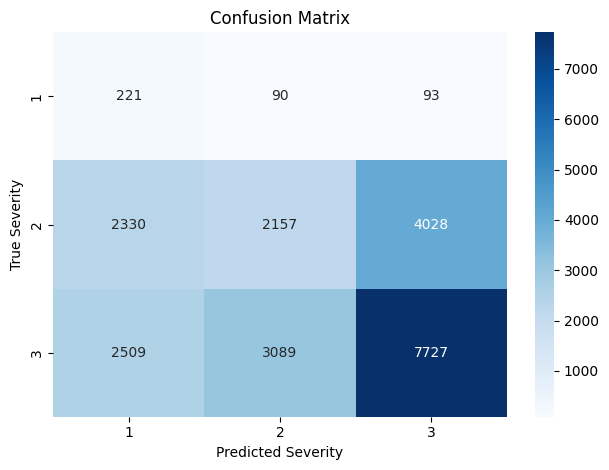

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

selected_features = ['LIGHT_CONDITION_GROUPED', 'SPEED_ZONE_GROUPED', 'ACCIDENT_TYPE_GROUPED', 'RMA']
X_train_rf4 = X_train[selected_features].copy()
X_test_rf4 = X_test[selected_features].copy()

for col in X_train_rf4.select_dtypes(include='object').columns:
    encoder = LabelEncoder()
    X_train_rf4[col] = encoder.fit_transform(X_train_rf4[col])
    X_test_rf4[col] = encoder.transform(X_test_rf4[col]) 

# Retraining
final_rf_model = RandomForestClassifier(
    class_weight='balanced',
    max_depth=10,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)
final_rf_model.fit(X_train_rf4, y_train)

# Prediction
y_pred_final = final_rf_model.predict(X_test_rf4)

print("Final Evaluation on Test Set (Random Forest, Tuned, 4 Features)")
print(classification_report(y_test, y_pred_final, labels=[0, 1, 2],
                            target_names=["Severity 1", "Severity 2", "Severity 3"], digits=4))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_final, labels=[0, 1, 2])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["1", "2", "3"], yticklabels=["1", "2", "3"])
plt.xlabel("Predicted Severity")
plt.ylabel("True Severity")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


In [8]:
# Reverse Mapping
label_mappings = {
    'SPEED_ZONE_GROUPED': ['High', 'Low', 'Medium', 'Very Low'],
    'ACCIDENT_TYPE_GROUPED': ['Collision', 'Non-Collision', 'Vulnerable Road User'],
    'RMA': ['Arterial Highway', 'Arterial Other', 'Freeway', 'Local Road'],
    'LIGHT_CONDITION_GROUPED': ['Darkness', 'Daylight', 'Twilight']
}
reverse_maps = {col: {i: label for i, label in enumerate(labels)} for col, labels in label_mappings.items()}

# Predict on the validation set and filter out samples predicted to be serious accidents
val_pred = best_rf_model.predict(X_val)
X_val_with_preds = X_val.copy()
X_val_with_preds["y_pred"] = val_pred
severe_cases = X_val_with_preds[X_val_with_preds["y_pred"] == 0]

# Output the label ratio in each feature
for col in features:
    counts = severe_cases[col].value_counts(normalize=True)
    print(f"\n Predicted severe accident distribution in {col}")
    for val, pct in counts.items():
        label = reverse_maps[col].get(val, f"Unknown({val})")
        print(f"  {label:<20}: {pct:.2%}")



 Predicted severe accident distribution in SPEED_ZONE_GROUPED
  High                : 59.57%
  Medium              : 27.62%
  Low                 : 12.79%
  Very Low            : 0.02%

 Predicted severe accident distribution in ACCIDENT_TYPE_GROUPED
  Collision           : 78.27%
  Vulnerable Road User: 17.31%
  Non-Collision       : 4.42%

 Predicted severe accident distribution in RMA
  Arterial Other      : 39.33%
  Local Road          : 26.73%
  Arterial Highway    : 18.18%
  Freeway             : 15.75%

 Predicted severe accident distribution in LIGHT_CONDITION_GROUPED
  Daylight            : 52.96%
  Darkness            : 26.25%
  Twilight            : 20.79%
